<a href="https://colab.research.google.com/github/heketor/TFN/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 


Utilizar mi dataset (enlaces de trafico), y con la LSTM predecir como va ser el trafico. Si aumenta la carga de trafico, poner mas recursos (bandwidth), con esto se resolveria en un prinpio el problema de *resource allocation*. Por otro lado utilizar DDLO pero en vez de pasarle el task_size. se va a alimentar con los datos anteriores para realizar la decision de offloading. 

Reduce delay.

Tengo que fijarme en que en DDLO le meto un vector de task size, eso me devuelve 3 vectore con las decisiones tomadas de las 3 redes. y computo Q para decidr cual es mejor y es la que le meto junto a es task size para entrenar

En vez de meterle a cara perro decisiones de offloading, podria ser una de los motivos por los que la red no esta aprendiendo.



### Important links 

[Pythorch Module Documentation](https://pytorch.org/docs/stable/nn.html#module)

[Pytorch nn tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html )

[Pytorch Tutorial](https://adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/)

[Colab Tutorial](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d )

[ Understanding LSTMs ](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Tensorboard in Pytorch Colab I](https://colab.research.google.com/github/SapanaChaudhary/Colab-pages/blob/master/Tensorboard_for_PyTorch.ipynb#scrollTo=aWV1w1AvLfiN)

[Tensorboard in Pytorch in Colab II](https://medium.com/logojoy-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34)

[Pytorch codes!!](https://github.com/yunjey/pytorch-tutorial)

[Activation Functions](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

**Mount Drive**


In [0]:

from google.colab import drive
drive.mount('/content/drive/')

#!ls -l "/content/drive/My Drive/TFM/RCLSTM/"
#!chmod 777 "/content/drive/My Drive/TFM/RCLSTM/rclstm.py"


#!cp "/content/drive/My Drive/TFM/RCLSTM/rclstm.py" "/content/rclstm.py"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Tensorboard

**KERAS**

In [0]:
# Ngrok executable can be directly downloaded to your Colab notebook
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

#TensorBoard in the background. It is assuming the TensorBoard log path is "./log"
It is assuming the TensorBoard log path is "./log"
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

#Run ngrok to tunnel TensorBoard port 6006 to the outside world
get_ipython().system_raw('./ngrok http 6006 &')

#Get the public URL where we can access the colab TensorBoard web page
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

**PYTORCH**

In [0]:
# Install latest Tensorflow build
!pip install -q tf-nightly-2.0-preview

# #Instantiate summay writers
# current_time = str(datetime.now().timestamp())
# train_log_dir = '/content/drive/My Drive/TFM/RCLSTM/logs/tensorboard/train/' + current_time
# test_log_dir = '/content/drive/My Drive/TFM/RCLSTM/logs/tensorboard/test/' + current_time
# train_summary_writer = summary.create_file_writer(train_log_dir)
# test_summary_writer = summary.create_file_writer(test_log_dir)

#Live Tensorboard

%tensorboard --logdir '/content/drive'


## Data proccessing






In [0]:
#!/usr/bin/env python3
# encoding: utf-8

import numpy as np 
import os
import time
import re

save_datetime = True
save_traffic = False
save_normalized = False

num_day = 10772  # numero de arhivos
num_ids = 23     # filas y columnas del csv
# path of csv files
dst_path = '/content/drive/My Drive/TFM/RCLSTM/data/csv/'
# initialize traffic matrix
Traffic_matrices = np.empty([num_day, num_ids, num_ids])
# initialize normalized traffic matrix
normalized_traffic_matrices = np.empty([num_day, num_ids, num_ids])
#Save the dictionary list of datetime
date_time = []

# get the traffic from point 1 to point 2
Traffic_matrices = np.load('/content/drive/My Drive/TFM/RCLSTM/data/traffic-matrices.npy')
time_step, src, dst = Traffic_matrices.shape
traffic_1_2 = []
for i in range(time_step):
    traffic_1_2.append(Traffic_matrices[i][0][1])
traffic_1_2 = np.array(traffic_1_2)
print(traffic_1_2.shape)
np.save('/content/drive/My Drive/TFM/RCLSTM/data/traffic-1-2.npy', traffic_1_2)
print('traffic-1-2 has been saved')

i = 0
# Sort file names
filenames = os.listdir(dst_path)
new_filenames = sorted(filenames)

for filename in new_filenames[1:]:
    # Save the date and time of the file in the dictionary
    if save_datetime:
        date_time_dict = {}
        portion = filename.split('-')
        date_time_dict['year'] = portion[1]
        date_time_dict['month'] = portion[2]
        date_time_dict['day'] = portion[3]
        date_time_dict['hour'] = portion[4]
        date_time_dict['min'] = portion[5].split('.')[0]
        date_time.append(date_time_dict)
    # Read Traffic matrix
    csvfile = open(os.path.join(dst_path, filename), 'rb')
    traffic_matrix = np.loadtxt(os.path.join(dst_path, filename), delimiter=',', skiprows=0)
    Traffic_matrices[i,:,:] = traffic_matrix

    i += 1

mu = np.mean(Traffic_matrices)
std = np.std(Traffic_matrices)
# print(mu, std)
normalized_traffic_matrices = (Traffic_matrices - mu) / std

# Save date-time as npy file
if save_datetime:
    np.save('/content/drive/My Drive/TFM/RCLSTM/data/date-time.npy', date_time)
    print('date-time dicts have been saved as npy file')

# Save traffic-matrices to npy file
if save_traffic:
    np.save('/content/drive/My Drive/TFM/RCLSTM/data/traffic-matrices.npy', Traffic_matrices)
    print('traffic matrices has been saved as npy file')

if save_normalized:
    np.save('/content/drive/My Drive/TFM/RCLSTM/data/normalized-traffic-matrices.npy', normalized_traffic_matrices)
    print('normalized traffic matrices has been saved as npy file')

# Read traffic-matrices data
# Traffic_matrices = np.load('/content/drive/My Drive/TFM/RCLSTM/data/traffic-matrices.npy')
# print('=='*30)
# normalized_traffic_matrices = np.load('/home/hyx/Pytorch/Traffic_prediction/data/normalized-traffic-matrices.npy')
# print(normalized_traffic_matrices[0][0]*std+mu)

(10772,)
traffic-1-2 has been saved


## Training LSTM

In [0]:
!pip install tensorboardcolab


  Stored in directory: /root/.cache/pip/wheels/c4/aa/a0/3aaf4f1a66adbdab9b7bdd4c96db8ada89eb7cd87200cfdd32
Successfully built tensorboardcolab


Data len after processing:  10759


,temp,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 91,Lag 92,Lag 93,Lag 94,Lag 95,Lag 96,Lag 97,Lag 98,Lag 99,Lag 100
100,0.526936,0.532788,0.547023,0.501063,0.513839,0.508366,0.521265,0.492559,0.494409,0.506479,...,0.477021,0.352035,0.422471,0.436998,0.479496,0.449577,0.416339,0.430000,0.480770,0.532821
101,0.540273,0.526936,0.532788,0.547023,0.501063,0.513839,0.508366,0.521265,0.492559,0.494409,...,0.539258,0.477021,0.352035,0.422471,0.436998,0.479496,0.449577,0.416339,0.430000,0.480770
102,0.500653,0.540273,0.526936,0.532788,0.547023,0.501063,0.513839,0.508366,0.521265,0.492559,...,0.524269,0.539258,0.477021,0.352035,0.422471,0.436998,0.479496,0.449577,0.416339,0.430000
103,0.492643,0.500653,0.540273,0.526936,0.532788,0.547023,0.501063,0.513839,0.508366,0.521265,...,0.518840,0.524269,0.539258,0.477021,0.352035,0.422471,0.436998,0.479496,0.449577,0.416339
104,0.516756,0.492643,0.500653,0.540273,0.526936,0.532788,0.547023,0.501063,0.513839,0.508366,...,0.513700,0.518840,0.524269,0.539258,0.477021,0.352035,0.422471,0.436998,0.479496,0.449577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,0.237266,0.347280,0.290197,0.331173,0.359224,0.260285,0.423201,0.378452,0.249774,0.253864,...,0.508270,0.480566,0.505662,0.518625,0.444280,0.476197,0.448437,0.521507,0.578357,0.474246
10755,0.318283,0.237266,0.347280,0.290197,0.331173,0.359224,0.260285,0.423201,0.378452,0.249774,...,0.489696,0.508270,0.480566,0.505662,0.518625,0.444280,0.476197,0.448437,0.521507,0.578357
10756,0.331291,0.318283,0.237266,0.347280,0.290197,0.331173,0.359224,0.260285,0.423201,0.378452,...,0.416738,0.489696,0.508270,0.480566,0.505662,0.518625,0.444280,0.476197,0.448437,0.521507
10757,0.321574,0.331291,0.318283,0.237266,0.347280,0.290197,0.331173,0.359224,0.260285,0.423201,...,0.351544,0.416738,0.489696,0.508270,0.480566,0.505662,0.518625,0.444280,0.476197,0.448437


the length of train_idx:  7461
the number of train data:  7461
the number of test data:  3198
the shape of input (train_X):  (7461, 100)
the shape of target (train_Y):  (7461,)
the number of batches:  233
LR is set to 0.01
the 0th iter, the 0th batch, train loss is 0.4722
the 0th iter, the 20th batch, train loss is 0.1678
the 0th iter, the 40th batch, train loss is 0.1160
the 0th iter, the 60th batch, train loss is 0.1108
the 0th iter, the 80th batch, train loss is 0.1129
the 0th iter, the 100th batch, train loss is 0.0875
the 0th iter, the 120th batch, train loss is 0.0883
the 0th iter, the 140th batch, train loss is 0.0958
the 0th iter, the 160th batch, train loss is 0.0735
the 0th iter, the 180th batch, train loss is 0.0775
the 0th iter, the 200th batch, train loss is 0.0925
the 0th iter, the 220th batch, train loss is 0.0617


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTMCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


the 1th iter, the 0th batch, train loss is 0.0824
the 1th iter, the 20th batch, train loss is 0.0788
the 1th iter, the 40th batch, train loss is 0.0741
the 1th iter, the 60th batch, train loss is 0.0688
the 1th iter, the 80th batch, train loss is 0.0646
the 1th iter, the 100th batch, train loss is 0.0815
the 1th iter, the 120th batch, train loss is 0.1037
the 1th iter, the 140th batch, train loss is 0.0580
the 1th iter, the 160th batch, train loss is 0.0861
the 1th iter, the 180th batch, train loss is 0.0663
the 1th iter, the 200th batch, train loss is 0.0799
the 1th iter, the 220th batch, train loss is 0.0767
the 2th iter, the 0th batch, train loss is 0.0682
the 2th iter, the 20th batch, train loss is 0.0921
the 2th iter, the 40th batch, train loss is 0.0795
the 2th iter, the 60th batch, train loss is 0.1173
the 2th iter, the 80th batch, train loss is 0.0667
the 2th iter, the 100th batch, train loss is 0.0867
the 2th iter, the 120th batch, train loss is 0.0982
the 2th iter, the 140th 

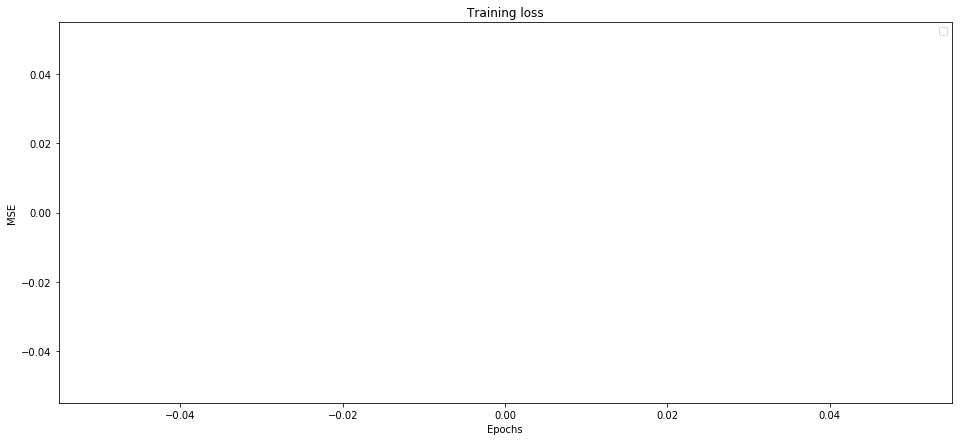

In [0]:
# encoding: utf-8

"""

@author: huayuxiu

"""


"""Train the model using traffic matrices."""
import argparse
import math
import os
import time
from datetime import datetime
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm
from collections import OrderedDict
import pandas as pd

!pip install tensorboardX 
from tensorboardX import SummaryWriter 

import tensorflow as tf

from tensorboardcolab import TensorBoardColab


# import tensorflow as tf
# from tensorflow import summary
# %load_ext tensorboard.notebook


np.random.seed(4)

# def get_args(parser):
#     parser.add_argument('--data', default='/content/drive/My Drive/TFM/RCLSTM/data/traffic-1-2.npy', help='path to dataset')
#     #parser.add_argument('--model', default='lstm', choices=['lstm', 'rclstm'], help='the model to use')
#     parser.add_argument('--connectivity', type=float, default=.5, help='the neural connectivity')
#     parser.add_argument('--save', default='./model', help='The path to save model files')
#     parser.add_argument('--hidden-size', type=int, default=200, help='The number of hidden units')
#     parser.add_argument('--batch-size', type=int, default=32, help='The size of each batch')
#     parser.add_argument('--input-size', type=int, default=1, help='The size of input data')
#     parser.add_argument('--max-iter', type=int, default=20, help='The maximum iteration count')
#     parser.add_argument('--gpu', default=False, action='store_true', help='The value specifying whether to use GPU')
#     parser.add_argument('--time-window', type=int, default=100, help='The length of time window')
#     parser.add_argument('--dropout', type=float, default=1., help='Dropout')
#     parser.add_argument('--num-layers', type=int, default=1, help='The number of RNN layers')
#     return parser

# # Get model parameters
# parser = argparse.ArgumentParser()
# parser = get_args(parser)
# args = parser.parse_args()
# print(args)

writer = SummaryWriter('/content/Graph/weights') # Saves the summaries to  the directory (weights and biases TB)
data_path = '/content/drive/My Drive/TFM/RCLSTM/data/traffic-1-2.npy'
#model_name = args.model
save_dir = '/content/drive/My Drive/TFM/RCLSTM/model'

#Colab form fields

#@markdown Parameters 

use_gpu = False  #@param {type: "boolean"}
tensorboard = False  #@param {type: "boolean"}
max_iter= 20  #@param {type: "slider", min: 0, max: 50}
hidden_size = 200 #@param {type: "number"}
batch_size = 32 #@param {type: "number"}
time_window = 100 #@param {type: "number"}
input_size = 1 #@param {type: "number"}
dropout = 0.1 #@param {type: "number"}
num_layers = 1 #@param {type: "number"}
#@markdown ---


if tensorboard == True: 
  tb = TensorBoardColab()

# Disrupt data set
def shufflelists(X, Y):
    ri=np.random.permutation(len(X)) #vector con valores aleatorios desde 1 hasta len(X)
    X_shuffle = [X[i].tolist() for i in ri]
    Y_shuffle = [Y[i].tolist() for i in ri]
    return np.array(X_shuffle), np.array(Y_shuffle)

# Load data and process data
data = np.load(data_path)  #raw_data [20232.5778 13492.2667  9087.5911 ...  4214.5333  3907.5289  3810.9689]

new_data = []
# Cargo el array con el trafico y lo normalizo con el logaritmo
for x in data:
    if x > 0:
        new_data.append(np.log10(x))
    else:
        new_data.append(0.0000001)
new_data = np.array(new_data) #Transform the python array into and np array
new_data = new_data[new_data>2.5]
data = new_data[new_data<6]
#Con esto de arriba consigo que todos los datos esten entre 2.5 y 6
# All data between 2.5 y 5.9
max_data = np.max(data)
min_data = np.min(data)
# Applying Min-Max scaling: [0,1]
data = (data-min_data)/(max_data-min_data)

print ('Data len after processing: ', data.size) # 10759 size 
# Ahora todo esta entre 0 y 1. [0.53282104 0.48076984 0.42999951 ... 0.33129056 0.32157426 0.31835984]
# Dataframe:  Use the pandas library to window the data and divide it into training and test sets.

df = pd.DataFrame({'temp':data})
pd.set_option('max_colwidth', 1000,'display.max_rows', 10)

# define function for create N lags
def create_lags(df, N):
    for i in range(N):
        df['Lag ' + str(i+1) ] = df.temp.shift(i+1)
    return df

# create time-windows lags
df = create_lags(df,time_window)

# the first 1000 days will have missing values. can't use them. (lagging)
df = df.dropna()
display(df)
# create X and y (matrix)
y = df.temp.values
X = df.iloc[:, 1:].values
# y --> only the first column (temp), X --> Rest of columns lags

# Train on 70% of the data 10659*0.7=7461 (number of train data)
train_idx = int(len(df) * .7)
print('the length of train_idx: ',train_idx)
# create train and test data
train_X, train_Y, test_X, test_Y = X[:train_idx], y[:train_idx], X[train_idx:], y[train_idx:]

print('the number of train data: ', len(train_X))
print('the number of test data: ', len(test_X))
print('the shape of input (train_X): ', train_X.shape)
print('the shape of target (train_Y): ', train_Y.shape)

# Calculate output and loss
def compute_loss_accuracy(loss_fn, data, label):
    hx = None
    # Aqui entra al forward(self, input_, hx=None) de RNN y luego a los otros 2
    # Le meto los batch de datos a entrenar en input_ = data
    _, (h_n, _) = model[0](input_=data, hx=hx)
    #print('h_n',h_n)
    #print('h_n shape',h_n.shape) #h_n shape torch.Size([1, 32, 200])
    logits = model[1](h_n[-1])
    loss = torch.sqrt(loss_fn(input=logits, target=label))
    return loss, logits

#learning rate decay. 3 steps decay to one tenth per training
def exp_lr_scheduler(optimizer, epoch, init_lr=1e-2, lr_decay_epoch=3):
    lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print("LR is set to {}".format(lr))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 
    return optimizer , lr


# Creates a criterion that measures the mean squared error between each element in the input x and target y.
loss_fn = nn.MSELoss()  

#Calcula el numero de batches que va a tomar dividiendo el numero de datos de entrenamiento entre el tamano de cada batch
num_batch = int(math.ceil(len(train_X) // batch_size))
num_batch = int(len(train_X) // batch_size)
print('the number of batches: ', num_batch)

#num_layers=1
# In PyTorch RNN(...) automatically calls the forward function so there is no need to explicitly call RNN.forward()        
rnn_model = RNN(input_size=input_size, hidden_size=hidden_size, 
                    num_layers=num_layers, batch_first=True, dropout=dropout)

#Fully connected layer. Applies a linear transformation to the incoming data: y = xA^T = b

fc2 = nn.Linear(in_features=hidden_size, out_features=input_size)

#A sequential container. Modules will be added to it in the order they are passed in the constructor. 
#Alternatively, an ordered dict of modules can also be passed in.

model = nn.Sequential(OrderedDict([('rnn', rnn_model),('fc2', fc2),]))

#print(model[0])  #RNN((cell_0): LSTMCell(1, 200))

#print(model[1])  #Linear(in_features=200, out_features=1, bias=True)

# Moves all model parameters and buffers to the GPU
if use_gpu:
    model.cuda()

optim_method = optim.Adam(params=model.parameters())
iter_cnt = 0
#max_iter = 20
#batch_size = 32
while iter_cnt < max_iter:
    train_inputs, train_targets = shufflelists(train_X, train_Y)
    optimizer , lr = exp_lr_scheduler(optim_method, iter_cnt, init_lr=0.01, lr_decay_epoch=3)
    #lr = 0.01
    #optimizer = optim_method
    for i in range(num_batch):
        # 0 32 | 32 64 | 64 96 | 96 128 y asi
        low_index = batch_size*i
        high_index = batch_size*(i+1)
        # Taking batches of size 32 for the input and target data
        if low_index <= len(train_inputs)-batch_size:
            # Me coje trocitos de 0 a 32
            #print('before reshape',train_inputs)
            #print('shape before reshape',train_inputs.shape)
            batch_inputs = train_inputs[low_index:high_index].reshape(batch_size, time_window, 1).astype(np.float32) # shape[32, 100, 1] esto son los inputs (lags) 
            # me lo pone en array 3D, Pasa de tener una matriz 2d de 7461 filas y 3 columnas a tener un array 3d con 32 matrices de 100 filas y 1 columna tipo
            # [[[0.46492657] ...
            #    [0.5248507 ]]
            #    ....
            #    [[0.38600665] ..
            #    [0.6526436 ]]]
            #print('after reshape',batch_inputs)
            #print('shape after reshape',batch_inputs.shape)

            batch_targets = train_targets[low_index:high_index].reshape((batch_size, 1)).astype(np.float32) # shape[32, 1] este es ahora el target que queremos conseguir 
        else:
            batch_inputs = train_inputs[low_index:].astype(float)
            batch_targets = train_targets[low_index:].astype(float)
            #print('Ha entrado en el else')
        # Create the Variable for the Autograd, converting the numpy array to Torch Tensor
        # Ahora crea los tensores pasa de np array a tensores
        batch_inputs = Variable(torch.from_numpy(batch_inputs), requires_grad=False)
        batch_targets = Variable(torch.from_numpy(batch_targets), requires_grad=False)
        # CUDA tensor types
        if use_gpu:
            batch_inputs = batch_inputs.cuda()
            batch_targets = batch_targets.cuda()
        # Sets the module in training mode
        model.train(True)
        
        # Sets gradients of all model parameters to zero.
        model.zero_grad()
        
        #Aqui es donde empieza a ejecutar el forward
        train_loss, logits = compute_loss_accuracy(loss_fn=loss_fn, data=batch_inputs, label=batch_targets)
        
        #print('train_loss',train_loss)
        #print('logits',logits)
        # Runs a back-propagation operation from the loss Variable backwards through the network
        # Scalar variables, when we call .backward() on them, don’t require arguments
        train_loss.backward()
        # Execute a gradient descent step based on the gradients calculated during the .backward() operation.
        optimizer.step()
        
        mean_loss = []
        # Weights, distributions and gradient scalars
        
        for f in model.parameters(): # model is the NN model, f is one set of parameters of the model
            # Create a dynamic name for the histogram summary 
            # Use current parameter shape to identify the variale  
            hist_name = 'hist' + str(list(f.grad.data.size()))

            # Save the entire list of gradients of parameters f 
            writer.add_histogram(hist_name, f, i)

            # Save the norm of list of gradients of parameters f 
            scalar_name = 'scalar' + str(list(f.grad.data.size()))
            writer.add_scalar(scalar_name, torch.norm(f.grad.data).item(), i)
            #parameter update step
            f.data.sub_(f.grad.data * lr) 

            #  Tensorboard Colab Magic 
            #   with train_summary_writer.as_default():
            #    tf.summary.scalar('loss', train_loss.data(), step=i)

        if i % 20 == 0:
            print('the %dth iter, the %dth batch, train loss is %.4f' % (iter_cnt, i, train_loss.data))
            mean_loss.append(train_loss.data)  
            #  Tensorboad Colab Library          
            if tensorboard == True: 
                tb.save_value('Train Loss', 'train_loss', i, train_loss.data)
        
    # Save the model once per iteration
            save_path = '{}/'.format(save_dir)
    if os.path.exists(save_path):
        torch.save(model, os.path.join(save_path, str(iter_cnt)+'.pt'))
    else:
        os.makedirs(save_path)
        torch.save(model, os.path.join(save_path, str(iter_cnt)+'.pt'))
    iter_cnt += 1
    
    
# Print the loss 

plt.figure(figsize=(16, 7))
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.plot(mean_loss)
plt.legend()
plt.show()

## **LSTM Cell / RNN**

In [0]:
# encoding: utf-8

"""

@author: huayux

"""

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional, init
import numpy as np
#from util import logFunction
import random
import math


# Building a basic LSTM unit
class LSTMCell(nn.Module):

    """A basic LSTM cell."""
# Parameters (input_size,hidden_size,bias) If false, the layer doesnt use bias weights b_ih/b_hh Default: true.
# __init__ represent the constructor in Python.
    def __init__(self, input_size, hidden_size):
        """
        Most parts are copied from torch.nn.LSTMCell.
        """
# weight_ih: the learnable input-hidden weights, of shape (4*hidden_size x input_size)
# weight_hh: the learnable hidden-hidden weights, of shape (4*hidden_size x hidden_size)
        super(LSTMCell, self).__init__()
        #self.op = logFunction()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = nn.Parameter(torch.FloatTensor(input_size, 4 * hidden_size))
        self.weight_hh = nn.Parameter(torch.FloatTensor(hidden_size, 4 * hidden_size))
        self.bias = nn.Parameter(torch.FloatTensor(4 * hidden_size))
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize parameters following the way proposed in the paper.
        """
        init.xavier_uniform_(self.weight_ih.data, gain=init.calculate_gain('sigmoid'))
        init.xavier_uniform_(self.weight_hh.data, gain=init.calculate_gain('sigmoid'))
        init.constant_(self.bias.data, val=0)

    def forward(self, input_, hx):
        """
        Args:
            input_: A (batch, input_size) tensor containing input
                features.
            hx: A tuple (h_0, c_0), which contains the initial hidden
                and cell state, where the size of both states is
                (batch, hidden_size).

        Returns:
            h_1, c_1: Tensors containing the next hidden and cell state.
        """
        #print('entra en el forward de RNN 1')
        h_0, c_0 = hx
        batch_size = h_0.size(0)
        bias_batch = (self.bias.unsqueeze(0).expand(batch_size, *self.bias.size()))
        wh_b = torch.addmm(bias_batch, h_0, self.weight_hh)
        wi = torch.mm(input_, self.weight_ih)
        f, i, o, g = torch.split(wh_b + wi, self.hidden_size, dim=1)
        c_1 = torch.sigmoid(f)*c_0 + torch.sigmoid(i)*torch.tanh(g)
        h_1 = torch.sigmoid(o) * torch.tanh(c_1)
        return h_1, c_1

    def __repr__(self):
        s = '{name}({input_size}, {hidden_size})'
        return s.format(name=self.__class__.__name__, **self.__dict__)



# Construct the RNN network. If cell_class is lstm, then the hidden neurons of the network are LSTM units;
# If cell_class is rclstm, then the hidden neuron of the network is rclstm
# The num_layer parameter indicates the number of network layers.
class RNN(nn.Module):

    """A module that runs multiple steps of LSTM or RCLSTM."""

    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=True, dropout=0):
    
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.dropout = dropout

        for layer in range(num_layers):
            layer_input_size = input_size if layer == 0 else hidden_size
            
            cell = LSTMCell(input_size=layer_input_size, hidden_size=hidden_size)
            
            setattr(self, 'cell_{}'.format(layer), cell)
        self.reset_parameters()

    def get_cell(self, layer):
        return getattr(self, 'cell_{}'.format(layer))

    def reset_parameters(self):
        for layer in range(self.num_layers):
            cell = self.get_cell(layer) # LSTMCell(1, 200)
            

    @staticmethod
    def _forward_rnn(cell, input_, hx):
        max_time = input_.size(0)
        #print(max_time)
        output = []
        for time in range(max_time):
            # Aqui entra en el primer forward
            h_next, c_next = cell(input_=input_[max_time-1-time], hx=hx)
            
            hx_next = (h_next, c_next)
            output.append(h_next)
            hx = hx_next
        output = torch.stack(output, 0)
        
        return output, hx

    def forward(self, input_, hx=None):
        if self.batch_first:
            #bath con los datos de entrada
            input_ = input_.transpose(0, 1)
        # (100,32,1) esto es lo que ha permutado antes era (32,100,1)    ahora tengo 100 matrices de 32 filas y 1 columna
        max_time, batch_size, _ = input_.size()
        #print(max_time)
        #print(batch_size)
        if hx is None:
            # hx es un tensor con zeros con las dimensiones que se le pasam
            hx = Variable(input_.data.new(batch_size, self.hidden_size).zero_())
            # torch.Size([32, 200])
            hx = (hx, hx)
           
        h_n = []
        c_n = []
        layer_output = None
        for layer in range(self.num_layers):
            cell = self.get_cell(layer)
            #Aqui entra en el segundo forward
            layer_output, (layer_h_n, layer_c_n) = RNN._forward_rnn(
                cell=cell, input_=input_, hx=hx)
            input_ = layer_output
            h_n.append(layer_h_n)
            c_n.append(layer_c_n)
        output = layer_output
        
        h_n = torch.stack(h_n, 0)
        c_n = torch.stack(c_n, 0)
        return output, (h_n, c_n)

## Test LSTM

In [0]:
# encoding: utf-8

"""

@author: huayuxiu

"""

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import data_processing
import time
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import logistic
import pandas as pd
import os
import math


data_path = '/content/drive/My Drive/TFM/RCLSTM/data/traffic-1-2.npy'
time_window = 100
hidden_size = 300
max_iter = 5

#download data
data = np.load(data_path)
new_data = []
for x in data:
    if x > 0:
        new_data.append(np.log10(x))
    else:
        new_data.append(0.001)
new_data = np.array(new_data)
new_data = new_data[new_data>2.5]
data = new_data[new_data<6]

max_data = np.max(data)
min_data = np.min(data)
data = (data-min_data)/(max_data-min_data)

df = pd.DataFrame({'temp':data})
# define function for create N lags
def create_lags(df, N):
    for i in range(N):
        df['Lag' + str(i+1)] = df.temp.shift(i+1)
    return df

# create time-windows lags
df = create_lags(df,time_window)

# the first 1000 days will have missing values. can't use them.
df = df.dropna()

# create X and y
y = df.temp.values
X = df.iloc[:, 1:].values

# Train on 70% of the data
train_idx = int(len(df) * .5)

# create train and test data
train_X, train_Y, test_X, test_Y = X[:train_idx], y[:train_idx], X[train_idx:], y[train_idx:]

test_X = test_X.reshape(-1, time_window, 1)
test_Y = test_Y.reshape(-1, 1)
print(len(test_X))

# Rebuild the LSTM calculation model and replace the matrix calculations in the model with the calculation of the sparse matrix
def rnn_cell(connectivity, input, hx, cell_weight_hh, cell_weight_ih, cell_bias):
    output = []
    for time in range(max_time):
        h, c = hx
        x = input[max_time-1-time]
        # print(h.shape)
        # print(cell_weight_hh.shape)
        # print(cell_bias.shape)

        # If the model is sparse, use the sparse matrix calculation method
        #if connectivity == '1' or connectivity == '10':
        #    wh_b = h * cell_weight_hh + cell_bias
        #    wi = x * cell_weight_ih

        # If the model is not sparse, use conventional calculation methods
        #else:
        wh_b = np.dot(h, cell_weight_hh) + cell_bias
        wi = np.dot(x, cell_weight_ih)
        f, i, o, g = np.split(wh_b + wi, 4, axis=1)
        c_next = np.multiply(logistic.cdf(f), c) + np.multiply(logistic.cdf(i), np.tanh(g))
        h_next = np.multiply(logistic.cdf(o), np.tanh(c))
        hx = (h_next, c_next)
        output.append(h_next)
        # if time % 50 == 0:
        #     print(time)
    output = np.stack(output, 0)
    return output, hx

def rnn(input, hx, cell_weight_hh, cell_weight_ih, cell_bias):
    input_ = np.transpose(input, [1, 0, 2])
    h_n = []
    c_n = []
    layer_output = None
    for layer in range(3):
        layer_output, (layer_h_n, layer_c_n) = rnn_cell(
            input=input_, hx=hx, cell_weight_hh=cell_weight_hh[layer],
            cell_weight_ih=cell_weight_ih[layer], cell_bias=cell_bias[layer])
        print(layer_output.shape)
        input_ = layer_output
        h_n.append(layer_h_n)
        c_n.append(layer_c_n)
    output = layer_output
    h_n = np.stack(h_n, 0)
    c_n = np.stack(c_n, 0)
    return output, (h_n, c_n)

# rclstm_model = torch.load('/home/hyx/Pytorch/Traffic_prediction/RNN/model/lstm-model.pt')
# rclstm_model_dict = rclstm_model.state_dict()
# print(rclstm_model_dict.keys())

RMSE = []
run_time = []
save_dir = './model/'
for connectivity in ['1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100']:
    save_path = save_dir + connectivity
    temp = []

    for save in range(max_iter):
        # print(os.path.join(save_path, str(save)+'.pt'))
        lstm_model = torch.load(os.path.join(save_path, str(save)+'.pt'))
        lstm_model_dict = lstm_model.state_dict()

        model_dict = lstm_model_dict

        cell_weight_ih_0 = model_dict['rnn.cell_0.weight_ih'].cpu().data.numpy()
        cell_weight_hh_0 = model_dict['rnn.cell_0.weight_hh'].cpu().data.numpy()
        cell_bias_0 = model_dict['rnn.cell_0.bias'].cpu().data.numpy()

        # If the weight matrix is sparse, the matrix is changed to a sparse matrix representation.
        if connectivity == '1' or connectivity == '10':
            cell_weight_ih_0 = csr_matrix(cell_weight_ih_0)
            cell_weight_hh_0 = csr_matrix(cell_weight_hh_0)
            print('sparse matrices')

        fc2_weight = model_dict['fc2.weight'].cpu().data.numpy()
        fc2_bias = model_dict['fc2.bias'].cpu().data.numpy()


        num_samples, max_time, _ = test_X.shape

        h = np.zeros((num_samples, hidden_size))
        c = np.zeros((num_samples, hidden_size))
        hx = (h, c)

        t1 = time.time()

        input_ = np.transpose(test_X, [1, 0, 2])

        h_n, _ = rnn_cell(connectivity, input_, hx, cell_weight_hh_0, cell_weight_ih_0, cell_bias_0)

        logit = np.dot(h_n[-1], fc2_weight.T) + fc2_bias
        t2 = time.time()

        prediction = logit
        actual = test_Y

        RMSELoss = np.sqrt(np.mean((actual - prediction)**2))

        # calculating time
        total_time = t2 - t1
        print('test RMSEloss is %.4f, total computating time is %.5f' % (RMSELoss, t2-t1))

        # Take the best performance of max-iter models as the final result
        if save == 0:
            temp = [RMSELoss, total_time]
        else:
            temp[0] = RMSELoss if RMSELoss < temp[0] else temp[0]
            temp[1] = total_time if total_time > temp[1] else temp[1]


    RMSE.append(float('%.4f' % temp[0]))
    run_time.append(float('%.4f' % temp[1]))

print(RMSE, run_time)

## Theory

---



**Min-Max Scaling **

Feature scaling is used to bring all values into the range [0,1]. This is also called unity-based normalization. 

**Variable Class**

The Variable class is the main component of this autograd system in PyTorch. This Variable class wraps a tensor, and allows automatic gradient computation on the tensor when the .backward() function is called (more on this later). The object contains the data of the tensor, the gradient of the tensor (once computed with respect to some other value i.e. the loss) and also contains a reference to whatever function created the variable (if it is a user created function, this reference will be null).

`x = Variable(torch_tensor, requires_grad=True)  `

require_grad = True specify that this variable requires a gradient. If we were using this in a neural network, this would mean that this Variable would be trainable. If we set this flag to False, the Variable would not be trained.

**CUDA semantics**

torch.cuda is used to set up and run CUDA operations. It keeps track of the currently selected GPU, and all CUDA tensors you allocate will by default be created on that device

** [Lags in Time Series Analysis](https://math.stackexchange.com/questions/2548314/what-is-lag-in-a-time-series)**

Lag is essentially delay. Just as correlation shows how much two timeseries are similar, autocorrelation describes how similar the time series is with itself.

Lags are very useful in time series analysis because of a phenomenon called autocorrelation, which is a tendency for the values within a time series to be correlated with previous copies of itself. One benefit to autocorrelation is that we can identify patterns within the time series, which helps in determining seasonality, the tendency for patterns to repeat at periodic frequencies. 

Finally, lags and autocorrelation are central to numerous forecasting models that incorporate autoregression, regressing a time series using previous values of itself. Autoregression is the basis for one of the most widely used forecasting techniques, the autoregressive integrated moving average model or ARIMA for short. Possibly the most widely used tool for forecasting, the forecast package by Rob Hyndman, implements ARIMA (and a number of other forecast modeling techniques). 


# Offloading MEC

We consider an MEC network composed by one edge server, one wireless access point (AP), and N WDs, denoted by a set $N = {1, 2, . . . , N}$



The AP and the edge server is connected by an optical fiber, whose transmission delay can be ignored.

Each WD has multiple tasks to be processed locally or be offloaded to the edge server via the AP. Without loss of generality, we assume that each WD has M independent tasks, denoted by a set $M = {1, 2, . . . , M}$. Denote $d_{nm}$ as the workload of the m-th task of user n. Each WD n can determine whether to offload its task m to the edge server or not, and the offloading decision is denoted by a binary variable $x_{nm} ∈ {0, 1}$. Specifically, $x_{nm}=1$ denotes that user n decides to offload its task m to the edge server, and $d_{nm}=0$ means that user n decides to execute its task m locally. The detailed operations of edge computing and local computing are illustrated as follows.
 
**Edge Commputing**

When a task is offloaded to the edge server, the WD n transmits its workload  dnm to the AP via wireless channels which is further forwarded to and processed at the edge server. We neglect the energy consumption and delay when the edge server transmits the computing results back to WDs. We denote $E_{nm}^{t}$
 as the energy consumed by WDs for uploading its workload to the edge server and model the energy cost for data process at edge server as a linear function of workload $d_{nm}$. Specifically, we denote the total cost for user $n$ to offload its task $m$ to the edge server as: 
 
 $$E_{nm}^{c} = E_{nm}^{t} + \alpha d_{nm}$$

where $α$ is the weight of the energy consumption at edge server. When $α = 0$, we only consider the energy consumption at WDs. Notice that the cost $E_{nm}^{c}$ includes the energy consumptions for sending the task and the server’s utility cost for executing this task. We next model the delay in computation offloading. Specifically, we use $c_{n}$ to denote the allocated bandwidth to user $n$ for transmitting its offloaded task to the edge server. Therefore,** the transmission delay** when user $n$ offloads its task $m$ to the edge server is given by:

$$T_{nm}^{t}=\frac{ d_{nm}}{c_{n}}$$

In addition, **the edge processing delay is given by** :

$$T_{nm}^{c}=\frac{ d_{nm}}{f^{c}}$$

where we denote ${f^{c}}$ as the edge processing rate. In
summary, given the offloading decisions ${x_{nm}}$, the total
delay of user n when it executes MEC can be given by:

$$T_{nm}^{c}={ \sum_{m=1}^{M}(T_{nm}^{c} + T_{nm}^{t}){x_{nm}}, \forall n}$$

We assume that the edge server can only start to process user n’s task m after this task is completely received by the edge, and the edge-server can only start to send back the output data after the entire task m is completed.

**Local Computing**

We next model the case when user n decides to execute its task locally. Specifically, we use $e_{n}^{l}$ to denote the local energy consumption per data bit of user n. Thus, user n’s energy consumption for executing its task m locally is given by:

 $$E_{nm}^{l}=d_{nm}e_{n}^{l}$$

Meanwhile, we denote user n’s local processing time per data bit as ${t^{l}}$. As a result, the total processing time for user n to execute its task m is given by:

$$T_{nm}^{l}=d_{nm}{t^{l}}$$

Thus, given user n’s offloading decision  ${x_{nm}}$, the total delay for user n to finish its tasks locally is given by:

$$T_{n}^{l}={ \sum_{m=1}^{M}T_{nm}^{l}(1 - {x_{nm})}, \forall n}$$

**Problem formulation**

To minimize both the total delay finishing all users’ tasks and the corresponding energy consumptions, we first introduce a system utility *Q(d, x, c)* defined as the weighted sum of energy consumption and task completion delay, as:

$$Q(d,x,c)=\sum_{m=1}^{M}(\sum_{m=1}^{M}(E_{nm}^{l}(1-x_{nm})+ E_{nm}x_{nm}) + \beta max [T_{n}^{l},T_{n}^{c}])$$

where $d=d_{nm}|n ∈ N, m ∈ M, x = x_{nm}|x ∈ N, m ∈ M, x =c_{n}|x ∈ N$ and $\beta$ denotes the weight of energy comsumption and task completition.

Now, we formulate the first optimization problem (P1) to minimize $Q(d,x,c)$ by jointly optimizing each user n's offloading decisions $x_{nm}$ and the bandwidth allocations $c_{n}$ for user n's task transmission, which is expressed as follows:


 $$(P1): Q^{*}(d) = \underset{x,c}{minimize} \hspace{0.5cm} Q(d,x,c)$$

$$\hspace{3.2cm} subject \hspace{0.1cm} to: \sum_{n=1}^{N}c_{n}\leq C,$$

$$\hspace{1.7cm}c_{n}\geqslant 0, \forall n ∈ N, $$

$$\hspace{1.1cm}x_{nm} ∈ [0,1]. $$


Here, constraint $\sum_{n=1}^{N}c_{n}\leq C$  means that the total uplink bandwidth allocation for all users cannot exceed the maximum bandwidth C. The allocated bandwidth for each user cn is
either 0 or positive. 

The optimization problem (P1) is a mixed-integer programming problem, which is difficult to solve in general. We will study an approximate algorithm based on deep learning to efficiently and effectively solve it.

